<a href="https://www.kaggle.com/code/prabhukirankonda/mnist-nn?scriptVersionId=118266909" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

In [2]:
train = MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test = MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

len(train), len(test)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(60000, 10000)

In [3]:
# train and validation split
# validation_data -> 20% of train data
validation_size = int(len(train)*0.2)
train_size = len(train) - validation_size

train_size, validation_size

(48000, 12000)

In [4]:
train, val = random_split(dataset=train, lengths=[train_size, validation_size])

len(train), len(test)

(48000, 10000)

In [5]:
# train and validation data loader
train_loader = DataLoader(dataset=train, shuffle=True, batch_size=128, num_workers=2)
val_loader = DataLoader(dataset=val, shuffle=False, batch_size=128, num_workers=2)

In [6]:
sample_images, sample_labels = next(iter(train_loader))

sample_images.shape

torch.Size([128, 1, 28, 28])

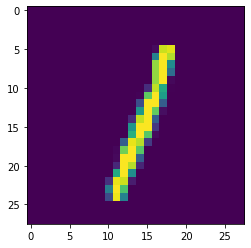

In [7]:
import matplotlib.pyplot as plt

plt.imshow(sample_images[0].view(28, 28))

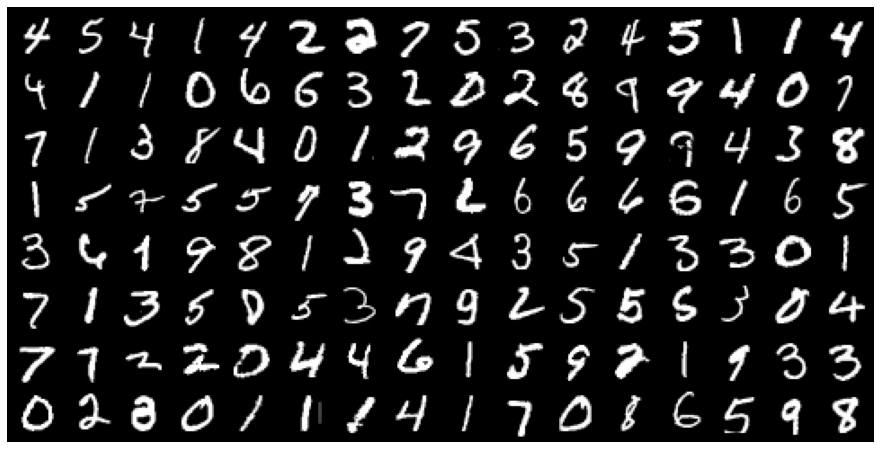

In [8]:
from torchvision.utils import make_grid

sample_images, sample_labels = next(iter(train_loader))
plt.figure(figsize=(16, 8))
plt.axis('off')
plt.imshow(make_grid(sample_images, nrow=16).permute(1, 2, 0))

In [9]:
input_size = 28*28
hidden_layer_size = 64
output_size = 10

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [11]:
class Mnist(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(nn.Linear(input_size, hidden_layer_size),
                                               nn.ReLU(inplace=True),
                                               nn.Linear(hidden_layer_size, hidden_layer_size),
                                               nn.ReLU(inplace=True),
                                               nn.Linear(hidden_layer_size, output_size))
        
        self.history = {
            'loss' : [],
            'acc' : [],
            'val_loss' : [],
            'val_acc' : []
        }
        
    def forward(self, x):
        x = x.view(-1, input_size)
        return self.linear_relu_stack(x)
        
        
    def fit(self, epochs, train_loader, val_loader, optimizer):
        for epoch in range(epochs):
            train_loss, train_acc = 0.0, 0.0
            val_loss, val_acc = 0.0, 0.0
            
            self.train()
            for images, labels in train_loader:
                optimizer.zero_grad()
                images, labels = images.to(device), labels.to(device)
                out = self(images)
                loss = F.cross_entropy(out, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * images.size(0)
                train_acc += torch.mean((out.argmax(dim=1) == labels).float()) * images.size(0)
                
            train_loss /= len(train_loader.dataset)
            train_acc /= len(train_loader.dataset)
            
            self.history['loss'].append(train_loss)
            self.history['acc'].append(train_acc.item())
            
            self.eval()
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    out = self(images)
                    loss = F.cross_entropy(out, labels)
                    val_loss += loss.item() * images.size(0)
                    val_acc += torch.mean((out.argmax(dim=1) == labels).float()) * images.size(0)
                
                val_loss /= len(val_loader.dataset)
                val_acc /= len(val_loader.dataset)
                
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc.item())
    
            print(f"Epoch: [{epoch+1}], Loss: {train_loss:5f}, Val Loss: {val_loss:.5f}, Accuracy: {train_acc:.5f}, Val Acc: {val_acc:.5f}")
        
model = Mnist()
model.to(device)

Mnist(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [12]:
!pip install torchinfo -q

In [13]:
import torchinfo

torchinfo.summary(model, (28, 28), batch_dim = 0, col_names = ("input_size", "output_size", "num_params"), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Mnist                                    [1, 28, 28]               [1, 10]                   --
├─Sequential: 1-1                        [1, 784]                  [1, 10]                   --
│    └─Linear: 2-1                       [1, 784]                  [1, 64]                   50,240
│    └─ReLU: 2-2                         [1, 64]                   [1, 64]                   --
│    └─Linear: 2-3                       [1, 64]                   [1, 64]                   4,160
│    └─ReLU: 2-4                         [1, 64]                   [1, 64]                   --
│    └─Linear: 2-5                       [1, 64]                   [1, 10]                   650
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
Total mult-adds (M): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.22
Estimated Total Size (MB): 0.22

In [14]:
optimizer = torch.optim.SGD(model.parameters(), 0.09)
model.fit(5, train_loader, val_loader, optimizer)

Epoch: [1], Loss: 0.873723, Val Loss: 0.38268, Accuracy: 0.75231, Val Acc: 0.88667
Epoch: [2], Loss: 0.324111, Val Loss: 0.28254, Accuracy: 0.90585, Val Acc: 0.92392
Epoch: [3], Loss: 0.259520, Val Loss: 0.24454, Accuracy: 0.92454, Val Acc: 0.93050
Epoch: [4], Loss: 0.212659, Val Loss: 0.21691, Accuracy: 0.93896, Val Acc: 0.93875
Epoch: [5], Loss: 0.178790, Val Loss: 0.18345, Accuracy: 0.94819, Val Acc: 0.94917


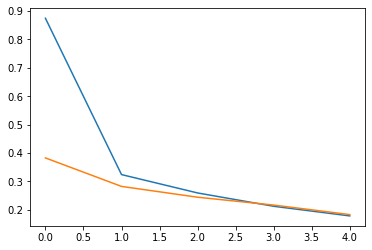

In [15]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])

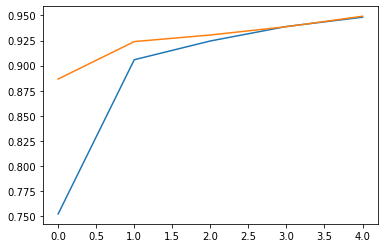

In [16]:
plt.plot(model.history['acc'])
plt.plot(model.history['val_acc'])

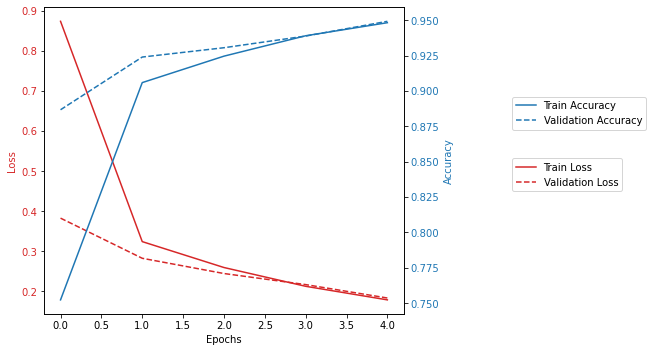

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 5))
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(model.history['loss'], color=color)
ax1.plot(model.history['val_loss'], color=color, linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['Train Loss', 'Validation Loss'], loc=(1.3, 0.4))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(model.history['acc'], color=color)
ax2.plot(model.history['val_acc'], color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Train Accuracy', 'Validation Accuracy'], loc=(1.3, 0.6))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [18]:
model(test[0][0].to(device)).argmax()

tensor(7, device='cuda:0')

In [19]:
test[0][1]

7

In [20]:
preds = [model(test[i][0].to(device)).argmax().item() for i in range(len(test))]
actual_labels = [test[i][1] for i in range(len(test))]

In [21]:
mask = (torch.tensor(preds) == torch.tensor(actual_labels))

In [22]:
total_correct_preds = torch.mean(mask.float()) * len(test)
wrong_preds = len(test) - total_correct_preds

In [23]:
total_correct_preds, wrong_preds

(tensor(9514.), tensor(486.))

In [24]:
torch.mean((torch.tensor(preds) != torch.tensor(actual_labels)).float()) * len(test)

tensor(486.)

In [25]:
false_indices = (~mask).nonzero().squeeze()
print(f'Indices of elements that are False: {false_indices}')

Indices of elements that are False: tensor([   8,  124,  149,  233,  241,  247,  259,  290,  320,  321,  324,  340,
         352,  381,  406,  412,  435,  445,  449,  464,  478,  479,  495,  502,
         543,  551,  565,  578,  582,  591,  659,  684,  691,  707,  717,  720,
         740,  760,  839,  844,  877,  882,  924,  938,  939,  947,  951,  956,
         965,  982, 1014, 1032, 1039, 1062, 1068, 1073, 1101, 1107, 1112, 1114,
        1124, 1128, 1181, 1192, 1194, 1198, 1200, 1204, 1224, 1226, 1232, 1242,
        1247, 1256, 1283, 1289, 1299, 1310, 1319, 1325, 1364, 1378, 1393, 1410,
        1414, 1429, 1433, 1440, 1444, 1466, 1467, 1494, 1500, 1522, 1525, 1527,
        1530, 1549, 1553, 1609, 1621, 1634, 1637, 1640, 1678, 1681, 1709, 1717,
        1737, 1751, 1754, 1759, 1773, 1790, 1800, 1828, 1850, 1857, 1878, 1901,
        1930, 1938, 1940, 1941, 1952, 1970, 1984, 2001, 2016, 2024, 2035, 2040,
        2043, 2044, 2053, 2068, 2070, 2093, 2098, 2099, 2109, 2118, 2129, 2130,
    

In [26]:
count = 0
wrong_idx = []
for i in range(len(preds)):
    if preds[i] != actual_labels[i]:
        count += 1
        wrong_idx.append(i)
count

486

In [27]:
len(test) - count

9514